# Anxiety of Conception Algorithm

This notebook contains the code and explanation for how the poems of my book, "The Anxiety of Conception," are ordered. In summary, I wrote one hundred prose poems (single paragraphs) in the year prior to J's birth, and one hundred in the year after. Let's consider then to be **part a** and **part b**. To create a book, first a mixture level is selected: how many poems from **part a** to swap with **part b**. Now we have *PART 1*, the first half of the book, which is mostly poems for **part a** but some from **part b**, and we have *PART 2*, the second half of the book, which is mostly poems from **part b** but some from **part a**. 

Then, an algorithm is used to determine which poems to swap and how to order the poems in each half. This algorithm results still in hundred poems for *PART 1* and a hundred for *PART 2*, but now some number have been swapped from the original **part a** and **part b**, and the order of each part has been selected be close to optimal given how the poems fit together. More details on the algorithm are specified with the code below.

There are 100 poems in each part, and 65 mixture levels, from 1 to 65. For each mixture level, the algorithm provides 10 close to optimal but distinct orderings. This means that the first 500 books represent a linear increase in the mixture level. After book 500, the mixture level oscillates between mixture levels 35 and 65 indefinitely.

## Step 1: import the poems

Import poems from **part a** and **part b**. Subset each set to just 100 poems each. (Eventually there should just be 100 poems in each part.) Then put them together into one large list which is referenced for the rest of the code, and just know that the first 100 are from **part a** and the second from **part b**.

The output of the algorithm with be an ordering: this will be a list of indices of this original list of poems. i.e. There are poems 0, 1, 2, 3, 4, ... 199. The output will be a list something like 5, 90, 23, 1, ... 182, representing the order in which the poems should be printed in the book.

Note that the imported text looks something like:

```
[1] Poem text here.

[2] Another poem text here.
```

Right now I'm removing the numbers in brackets, but I may consider putting them back later.

In [1]:
import string
from nltk.stem.porter import *

stemmer = PorterStemmer()

def simple_tokenize(s):
    """where s is a string of text, raw poem"""
    s = s.lower()
    s = s.translate(str.maketrans('', '', string.punctuation))
    return s.split(" ")

def get_stems(s):
    """where s is a list of lowercase words"""
    return [stemmer.stem(w) for w in s]


data_raw = []
data_tokens = []
data_stems = []

# first add part a
with open("part_a.txt", "r") as fle:
    for line in fle:
        if line[0] == "[":
            text = line.split("]")[1].strip()
            data_raw.append(text)

            tokens = simple_tokenize(text)
            data_tokens.append(tokens)

            stems = get_stems(tokens)
            data_stems.append(stems)

# cut it to just 100 poems
data_raw = data_raw[:100]
data_tokens = data_tokens[:100]
data_stems = data_stems[:100]

poems_a = list(range(len(data_raw)))
            
# then add part b
with open("part_b.txt", "r") as fle:
    for line in fle:
        if line[0] == "[":
            text = line.split("]")[1].strip()
            data_raw.append(text)

            tokens = simple_tokenize(text)
            data_tokens.append(tokens)

            stems = get_stems(tokens)
            data_stems.append(stems)

data_raw = data_raw[:200]
data_tokens = data_tokens[:200]
data_stems = data_stems[:200]            

poems_b = list(range(poems_a[-1]+1, len(data_raw)))

split_index = poems_a[-1] + 1

print(poems_a)
print(poems_b)
print(split_index)
data_raw[0], ' '.join(data_tokens[0]), ' '.join(data_stems[0])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
100


('I visualize two paths my life might take. The one where I have a child and the one where I do not. I try to place them on equal footing, imagining each as something I truly want. Though I know both will be filled with disappointment and loss.',
 'i visualize two paths my life might take the one where i have a child and the one where i do not i try to place them on equal footing imagining each as something i truly want though i know both will be filled with disappointment and loss',
 'i visual two path my life might take the one where i have a child and the one where i do not i tri to place them on equal foot imagin each as someth i truli want though i know both will be fill with disappoint and loss')

## Step 2: calculate transition scores

i.e. How well one poem flows into another. 

Look at the 10 words at the end of one poem, the 10 at the start of the next. High score is better, but then we'll invert it so that score is more like distance (where lower is better).

Initial score: 0

If a word in poem B is in poem A:

* If not a stop word:
    * +10 if exact word match OR
    * +5 if stemmed word match
* If narrow stop word:
    * +2
* If broad stop word
    * +4
    
Not implemented: 

* Check number of words between them (k) -- could be up to 18
    * -k/4

I'd like this score to be a bit cleaner, and maybe consider distance between words, but this is working pretty well for now.

In [2]:
stopwords_broad = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
stopwords_narrow = ["the", "a", "an"]

def join_score(a, b, n=10):
    """where a and b are indices for the data, and n is num of words to consider"""
    score = 0
    a_tokens = data_tokens[a]
    a_stems = data_stems[a]
    b_tokens = data_tokens[b]
    b_stems = data_stems[b]
    for i in range(min(len(a_tokens), n)): # iterate over words in a
        a_token = a_tokens[-i]
        a_stem = a_stems[-i]
        for j in range(min(len(b_tokens), n)): # iterate over words in b
            b_token = b_tokens[j]
            b_stem = b_stems[j]
            if a_token == b_token: # if there's a matching word
                if a_token in stopwords_narrow:
                    score += 2
                    continue
                if a_token in stopwords_broad:
                    score += 4
                    continue
                score += 10
                continue
            if a_stem == b_stem:
                score += 5
    return 20 - score

p = 2
q = 3
print(data_raw[p])
print(data_raw[q])
join_score(p, q)

A mood sweeps in like a fog. I no longer know where it came from. I get stuck in circles. I try to ignore the suspense; anger and hurt can do that well, but not entirely. Suspense is lodged within me, someplace deep. The fog crawls at my feet. Let me stay, it mews, and though I definitely want it to leave, it doesn’t feel entirely up to me.
I pause to look carefully at the book cover. I am obsessed with the way books feel, how they look. Their aspect ratio, the texture of the paper. If I put my nose close, I can see the dot matrix of the printed artwork. It’s not grey; it’s white with a multitude of black dots.


12

In [3]:
import numpy as np

def calc_all_scores(data, join_score_func):
    scores = np.empty([len(data), len(data)])
    for i in range(len(data)):
        for j in range(len(data)):
            if i == j:
                s = np.nan
            else:
                s = join_score_func(i, j)
            scores[i][j] = s
    return scores

In [4]:
scores = calc_all_scores(data_raw, join_score)

In [5]:
scores

array([[nan,  6., 16., ..., 20., 16., 16.],
       [12., nan, 16., ..., 12., 12.,  8.],
       [20., 12., nan, ...,  0., 20., 12.],
       ...,
       [20., 12., 20., ..., nan, 20., 16.],
       [12., 16., 16., ..., 20., nan, 16.],
       [16., 12., 16., ..., 16., 16., nan]])

## Step 2a: see which poems fit together best

This is just to check that the join scores are working okay.

Remember: lower is better, because the scores are considered as "distances" between the poems.

In [6]:
def get_top_scores(scores, asc=True, n=5):
    flattened = scores.flatten()
    if asc:
        sorted_indices = np.argsort(flattened)
    else:
        sorted_indices = np.argsort(-flattened)
    indices_2d = np.unravel_index(sorted_indices, scores.shape)
    sorted_indices_list = list(zip(indices_2d[0], indices_2d[1]))
    
    for i, val in enumerate(sorted_indices_list[0:n]):
        print('indices:', val)
        print('score:', scores[val[0],val[1]])
        print('>>>', data_raw[val[0]], '\n>>>>', data_raw[val[1]], '\n')

    return sorted_indices_list

In [7]:
x = get_top_scores(scores, asc=True, n=10)

indices: (89, 91)
score: -28.0
>>> I try to live in Lispector's now-instant, whose mucused birth slips into departure too quickly. I am awake in the night. My breathing slows and then speeds. I conceive of the moment and it swims out of my grasp. I become fish and the moments slick by, I cannot stop moving. I am here and here and here. Fish become mammal become fish again. Whales and dolphins taking great gasps of air and then holding their breathe as if they could still breath water. I can no longer breath water. I am quadrant, rectangle, square, polygon. My moment becomes circle and then fractals out like pond ripples, concentric not spiral, the moments are this and this and this and this. 
>>>> I wake and I wake and I wake and every time I lay in bed for an hour because I am tired but my mind it lunges out ahead of me and I try to just breath as if I could conceive of breathing as my only task but the tension coils inside me like a good spring ready to give back its energy whenever 

## Step 3: find a close-to-optimal ordering of poems

### A single tour (if we don't care about the two parts and mixture levels)

This is a traveling salesman problem with assymmetric distances. To keep in line with traveling salesman terminology, each poem is a "city", and the ordering of the poems is called the "tour". The scores between poems are "distances". It's assymmetric because the distance between two poems (cities) depends on their order.

The algorithm calculates a "tour" which visits each city once. I'm going to use a Markov Chain Monte Carlo (MCMC) method to stochastically find a good tour. The basic idea is to start with a random tour, and then randomly swap cities (poems) and check if the new tour is better; then we repeat this many times. However, to avoid local minimums, we add some wiggle room for selecting a slightly less optimal tour. We'll add in what's called simulated annealing, which means we'll decrease the wiggle room as we go on.

Shouldn't take more than a second or two to run this algorithm with 50k iterations.

### A double tour (caring about the mixture of the two parts)

Actually, I have two tours: the cities (poems) of part A, and the cities (poems) or part B. Both should be close-to-optimal. 

I'd like to be able to create mixtures of part A and part B. To do this, I set a mixture percentage, and then randomly swap that percentage of cities. So let's say the percentage is 30%. I randomly select 30% of cities from part A and swap it with 30% from part B. Let's imagine cities have colors, and those colors represent which part they originally come from. So originally we have blue cities in part A and red cities in part B. Then we mix 30%. Now part A is mostly blue, but with some red, and part B is mostly red, but with some blue.

Then we do the MCMC on the tour like usual, but with a constraint on how cities can be swapped. Normally, with a single tour, you can swap any city with any other. Now a city can be swapped with:

* any other city in the same part (e.g. if from part A, it can be swapped with any other city in part A)
* any other city with the same color (e.g. if blue, it can be swapped with any other blue city)

This means that, e.g., a blue city in part A can be swapped with any city in part A (red or blue) or any blue city (in part A or part B). 

The idea here is that by allowing swaps into the other part, but of the same color, we can mix up the cities between the parts *without changing the mixture percentage*. 

Now, when we decide if we want to keep a swap, we want to calculate the distance of each tour independently (the tour through part A and the tour through part B) and then only accept a swap if *both* tours improve.

### A note on optimality

It is very computationally expensive to find the optimal tour---this is an NP-hard problem. Instead, MCMC gives us a close-to-optimal tour. What is nice about MCMC is that because it finds a close-to-optimal tour stochastically, you can run the algorithm multiple times and get multiple distinct tours all of which are close-to-optimal.

### Some pseudocode

This can be implemented basically the same way as the single tour, but now the tour contains part A and part B (let's consider them really to be tour A and tour B) and we need to keep track of the split index -- the index of the last city in tour A. Then, the only difference is:

* constraints on the kinds of swaps that are allowed
* extra constraint on when to keep a swap (calculate two tour distances; both must improve)

In [8]:
# uses the following variables from above:
# poems_a, poems_b, split_index

import random
import math

def calculate_total_distance(tour, distance_matrix):
    return sum(distance_matrix[tour[i]][tour[i+1]] for i in range(len(tour)-1))

def swap_cities(tour):
    new_tour = tour[:]
    # old way: can swap any two cities
#     i, j = random.sample(range(len(tour)), 2)
    # new way: randomly select one city, then constraint second swap
    [(i, city)] = random.sample(list(enumerate(tour)), 1) # i is location in tour, city is index of city
    if city in poems_a: # if city is from original A set
        if i < split_index: # if city is in tour A
            acceptable_swaps = tour[:split_index] + [c for c in tour[split_index:] if c in poems_a]
        else: # if city is in tour B
            acceptable_swaps = tour[split_index:] + [c for c in tour[:split_index] if c in poems_a]
    else: # if city is from original B set
        if i < split_index: # if city is in tour A
            acceptable_swaps = tour[:split_index] + [c for c in tour[split_index:] if c in poems_b]
        else: # if city is in tour B
            acceptable_swaps = tour[split_index:] + [c for c in tour[:split_index] if c in poems_b]
    # sample from acceptable_swaps, then find index of that sample in current tour
    j = tour.index(random.sample(acceptable_swaps, 1)[0])
    
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour

def solver(distance_matrix, iterations, initial_temperature, mixture):
    # mixture should be an int between 1 and 50
    # here we're just assuming that there are 100 poems in each part
    # just makes the mixing easier to implement in code
    # since it doesn't really matter which poems get swapped, we just swap from the start
    tour_a = poems_b[:mixture] + poems_a[mixture:]
    tour_b = poems_a[:mixture] + poems_b[mixture:]
    
    current_tour = tour_a + tour_b
    
    current_distance_a = calculate_total_distance(tour_a, distance_matrix)
    current_distance_b = calculate_total_distance(tour_b, distance_matrix)
    
    best_tour = current_tour
    best_distance_a = current_distance_a
    best_distance_b = current_distance_b

    temperature = initial_temperature

    # these three lines are for recording the distances as iterations progress
    down_sample = 100 
    distance_array_a = np.empty(int(iterations/down_sample))
    distance_array_b = np.empty(int(iterations/down_sample))

    for iteration in range(iterations):
        if iteration%down_sample == 0:
            distance_array_a[int(iteration/down_sample)] = current_distance_a
            distance_array_b[int(iteration/down_sample)] = current_distance_b
            
        new_tour = swap_cities(current_tour)
        
        new_distance_a = calculate_total_distance(new_tour[:split_index], distance_matrix)
        new_distance_b = calculate_total_distance(new_tour[split_index:], distance_matrix)
        
        delta_distance_a = new_distance_a - current_distance_a
        delta_distance_b = new_distance_b - current_distance_b

        if delta_distance_a < 0 or random.random() < math.exp(-delta_distance_a / temperature):
            if delta_distance_b < 0 or random.random() < math.exp(-delta_distance_b / temperature):
                current_tour = new_tour
                current_distance_a = new_distance_a
                current_distance_b = new_distance_b
                
                if new_distance_a < best_distance_a and new_distance_b < best_distance_b:
                    best_tour = new_tour
                    best_distance_a = new_distance_a
                    best_distance_b = new_distance_b

        temperature *= 0.999  # Cooling schedule

    return best_tour, best_distance_a, best_distance_b, distance_array_a, distance_array_b


cities = list(range(len(data_raw)))  
dist_matrix = scores  # the asymmetric distance matrix
iterations = 50000
init_temp = 100
mixture = 20

best_tour, best_dist_a, best_dist_b, dist_arr_a, dist_arr_b = solver(dist_matrix, iterations, init_temp, mixture)
print("Best Tour:", best_tour)
print("Best Distance:", best_dist_a, best_dist_b)

Best Tour: [4, 92, 81, 24, 77, 19, 155, 15, 44, 57, 83, 171, 187, 45, 30, 1, 52, 150, 6, 39, 72, 74, 79, 0, 7, 96, 18, 82, 169, 5, 11, 146, 78, 42, 93, 88, 53, 71, 38, 118, 80, 84, 8, 16, 3, 142, 46, 55, 41, 179, 86, 69, 13, 99, 32, 35, 103, 67, 129, 158, 190, 76, 28, 37, 50, 62, 26, 68, 87, 98, 110, 90, 177, 29, 34, 152, 127, 60, 2, 12, 97, 14, 20, 21, 31, 56, 167, 59, 94, 64, 95, 10, 54, 63, 128, 104, 70, 51, 49, 65, 105, 119, 143, 141, 43, 132, 154, 173, 172, 197, 48, 106, 181, 120, 40, 166, 124, 147, 144, 134, 73, 117, 25, 101, 125, 135, 168, 133, 153, 123, 140, 27, 170, 23, 9, 66, 151, 130, 113, 33, 199, 137, 176, 165, 17, 182, 178, 111, 148, 149, 114, 108, 136, 47, 195, 126, 193, 192, 194, 191, 100, 189, 102, 112, 36, 156, 89, 91, 115, 186, 131, 107, 185, 198, 188, 121, 139, 145, 138, 183, 180, 174, 175, 157, 75, 61, 58, 160, 122, 109, 161, 163, 196, 184, 116, 159, 164, 162, 22, 85]
Best Distance: 688.0 629.0


### Check that the mixture level is correct

In [9]:
tour_a = best_tour[:split_index]
tour_b = best_tour[split_index:]

print("B poems in tour A:", len([p for p in tour_a if p in poems_b]))
print("A poems in tour A:", len([p for p in tour_a if p in poems_a]))
print('\n')
print("A poems in tour B:", len([p for p in tour_b if p in poems_a]))
print("B poems in tour B:", len([p for p in tour_b if p in poems_b]))


B poems in tour A: 20
A poems in tour A: 80


A poems in tour B: 20
B poems in tour B: 80


## Step 4: see how well the solver is working

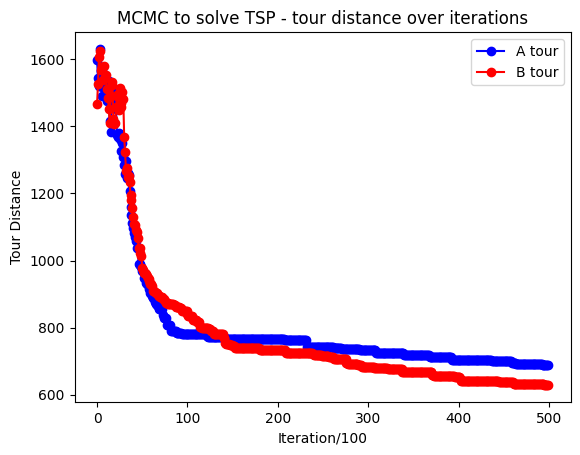

In [10]:
import matplotlib.pyplot as plt

# Generate x-axis values (indices of the array)
indices = np.arange(len(dist_arr_a))

# Create a line plot
plt.plot(indices, dist_arr_a, c='b', marker='o')
plt.plot(indices, dist_arr_b, c='r', marker='o')
plt.legend(["A tour", "B tour"])

# Add titles and labels
plt.title('MCMC to solve TSP - tour distance over iterations')
plt.xlabel('Iteration/100')
plt.ylabel('Tour Distance')

# Show the plot
plt.show()


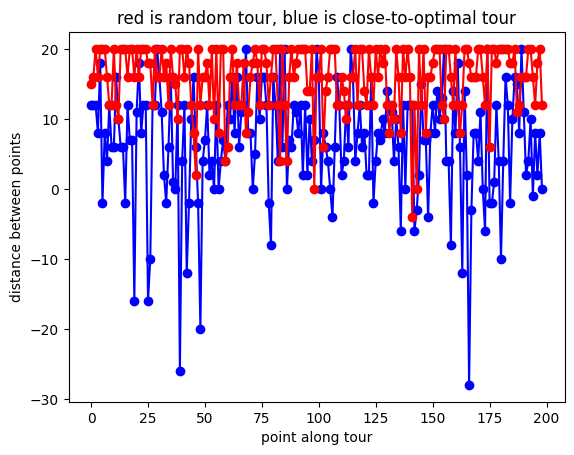

In [11]:
def get_tour_scores(tour):
    score_list = []
    for i in range(len(tour)-1):
        score_list.append(scores[tour[i], tour[i+1]])
    return score_list

random_tour = random.sample(list(range(len(data_raw))), len(data_raw))

best_score_list = get_tour_scores(best_tour)
rand_score_list = get_tour_scores(random_tour)

indices = np.arange(len(best_score_list))

# Create a line plot
plt.plot(indices, best_score_list, c='b', marker='o')
plt.plot(indices, rand_score_list, c='r', marker='o')

# Add titles and labels
plt.title('red is random tour, blue is close-to-optimal tour')
plt.xlabel('point along tour')
plt.ylabel('distance between points')

# Show the plot
plt.show()

### Let's see the mixture

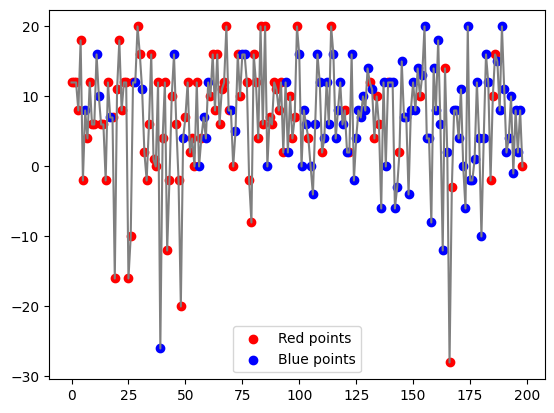

In [12]:
indices = np.arange(len(best_tour[:199]))

indices_a = [i for i,p in enumerate(best_tour[:199]) if p in poems_a]
indices_b = [i for i,p in enumerate(best_tour[:199]) if p in poems_b]

# Plotting the line connecting all points
plt.plot(indices, best_score_list, linestyle='-', color='gray')  # Use any color for the line

# Plotting red points
plt.scatter([indices[i] for i in indices_a], [best_score_list[i] for i in indices_a], color='red', label='Red points')

# Plotting blue points
plt.scatter([indices[i] for i in indices_b], [best_score_list[i] for i in indices_b], color='blue', label='Blue points')

# Optional: Adding a legend
plt.legend()

# Show the plot
plt.show()

## Step 5: let's write a whole bunch of books!

Some details about writing books:

* I set a random seed so that books generated at the same every time. *I haven't confirmed that this is actually working correctly yet, the random seed part. Ideally whenever we generate book number X, it's the same, even though it's determined stochastically.*
* After we get to 500 books (or mixture level 50) the mixture level will oscillate. We can think about if this is the right move or not (e.g. should the mixture level go all the way back down to 0? Should it ever go all the way up to 100?) Right now it's a saw-tooth function, but could be fun if it was a sine wave?
* I keep track of past books to make sure no book is ever an exact repeat of one before. This is extremely unlikely, and I haven't yet tested that this is working perfectly. 


In [61]:
import json

def reset_prev_tours():
    """
    !!! running this deletes the record of previous tours !!!
    !!! be careful !!!
    """
    prev_tours = {}

    with open("prev_tours.txt", "w") as fle:
        json.dump(prev_tours, fle)

# reset_prev_tours()

In [62]:
def get_mixture_level(book_num, start_num=50, cycle=30):
    """return integer mixture level"""
    mixture = book_num//10
    if mixture <= start_num:
        return mixture
    baseline = start_num - (cycle//2)
    mixture = mixture - baseline
    if mixture % (2*cycle) < cycle:
        return baseline + (mixture % cycle)
    return baseline + cycle - (mixture % cycle)

Test how the mixture level cycles as book numbers increase.

Text(0, 0.5, 'mixture level')

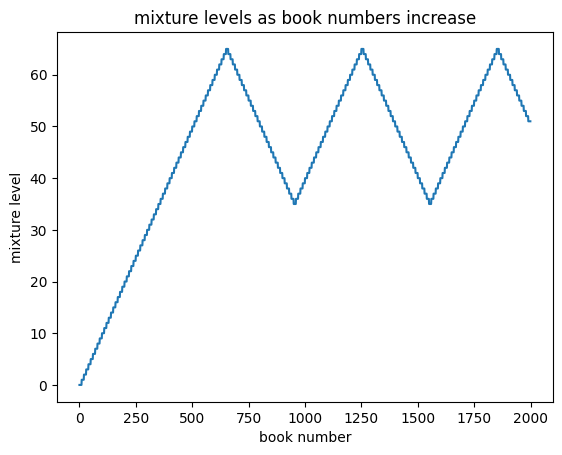

In [63]:
book_numbers = list(range(0,2000))
mixture_levels = [get_mixture_level(n, cycle=30) for n in book_numbers]

plt.plot(book_numbers, mixture_levels)

plt.title('mixture levels as book numbers increase')
plt.xlabel('book number')
plt.ylabel('mixture level')

In [64]:
random.seed(30324)

cities = list(range(len(data_raw)))  
dist_matrix = scores  # the asymmetric distance matrix
iters = 50000
init_temp = 100

with open("prev_tours.txt", "r") as fle:
    prev_tours = json.load(fle)

def write_book(book_num):
    """book_num is an integer"""
    mixture = book_num//10
    period = 30  # this is the cycle length for after we hit a mixture level of 50
    mixture = get_mixture_level(book_num, cycle=period)
    print("mixture level", mixture)
    best_tour, best_dist_a, best_dist_b, dist_arr_a, dist_arr_b = solver(dist_matrix, iters, init_temp, mixture)
    
    # check that the tour isn't a repeat; if not, add to list and save
    for key in prev_tours:
        if prev_tours[key] == best_tour:
            print("OH NO, REPEATED TOUR!")
            return
    prev_tours[str(book_num)] = best_tour
    with open("prev_tours.txt", "w") as fle:
        json.dump(prev_tours, fle)
    
    flename = f"best_tour_booknum{book_num}.txt"
    with open(f"output_tours/{flename}", 'w') as fle:
        for k, index in enumerate(best_tour[:-1]):
            if k == split_index:
                fle.write("\n\n***\n\n\n\n")
            poem = data_raw[index]
            score = scores[index, best_tour[k+1]]
            fle.write(f"{poem}\n\n")

In [66]:
write_book(1000)

mixture level 40
